# A Neural Engineering Framework Representation of the Kalman Filter
## Introduction
The Kalman Filter is a method for estimating unknown or hidden system states using an internal model of the physical processes at work. First we need to construct the physical process that we are trying to find estimates for. Modelling kinematic motion can be done through state space equation in discrete time using simple forward integration. For system dynamics in the horizontal axis of the 2D plane let $$x[n+1] = x[n] + \dot{x} * dt$$ and system dynamics in the vertical axis be $$y[n+1] = y[n] + \dot{y}[n] * dt$$ where $$\dot{y}[n+1] = \dot{y}[n] + \ddot{y} * dt$$ The State Variables that we want to estimate are going to be $x[n], \dot{x}[n], y[n], \dot{y}[n], \ddot{y}[n]$. In state space this gives us 
$$
 \begin{bmatrix}
 x[n+1] \\
 \dot{x}[n+1] \\
 y[n+1] \\
 \dot{y}[n+1] \\
 \ddot{y}[n+1]
 \end{bmatrix}
 =
 \begin{bmatrix}
 1 & dt & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 0 \\
 0 & 0 & 1 & dt & 0 \\
 0 & 0 & 0 & 1 & dt \\
 0 & 0 & 0 & 0 & 1
 \end{bmatrix}
 \begin{bmatrix}
 x[n] \\
 \dot{x}[n] \\
 y[n] \\
 \dot{y}[n] \\
 \ddot{y}[n]
 \end{bmatrix}
$$
The noisy measurement values that we are able to observe will be $x[n]$ and $y[n]$. Using the kalman filter we will both be able to achieve some amount of tracking and estimate the true values of the rest of the states.

In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [118]:
def system_dynamics(x, dt):
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    next_state = A @ x
    return next_state

def output_from_state(x):
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    return C @ x

def kalman_filter_trad(x_hat, next_y, dt):
    return None


def kalman_filter(x_hat, next_y, dt):
    return kalman_filter_course(x_hat, next_y, dt)
    
def kalman_filter_course(x_hat, next_y, dt):
    variance_y = 1
    variance_x = 1
    A = np.array([
        [1, dt, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, dt],
        [0, 0, 0, 0, 1]
    ])
    C = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
    P = (1 / variance_x) + (C.T @ C / variance_y)
    next_x_hat = np.linalg.pinv(P) @ (((A @ x_hat) / variance_x) + ((C.T @ next_y)) / variance_y)
    return next_x_hat

In [124]:
t_length = 1
num_samples = 100
t_space = np.linspace(0, t_length, num=num_samples)
dt = t_length / num_samples

# Create Random Noise
noise_mean = 0
noise_std = 1
random_noise = np.random.normal(noise_mean, noise_std, (num_samples, 2, 1))

# Initialize state and output recorders
state_recorder = np.array([[[0], [2], [10], [0], [-9.81]]])
output_recorder = np.array([output_from_state(state_recorder[0]) + random_noise[0]]) 
prediction_recorder = np.array([kalman_filter(np.array([[0, 0, 0, 0, 0]]).T, output_recorder[0], dt)])

# Initialize next state and next output
next_state = [system_dynamics(state_recorder[0], dt)]
next_output = [output_from_state(next_state[0]) + random_noise[1]]
next_estimate = [kalman_filter(prediction_recorder[0], next_output[0], dt)]

state_recorder = np.append(state_recorder, next_state, axis=0)
output_recorder = np.append(output_recorder, next_output, axis=0)
prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)

for _, (t, rand_n) in enumerate(zip(t_space[2:], random_noise[2:, :])):
    next_state = [system_dynamics(next_state[0], dt)]
    next_output = [output_from_state(next_state[0]) + rand_n]
    next_estimate = [kalman_filter(next_estimate[0], next_output[0], dt)]
    
    state_recorder = np.append(state_recorder, next_state, axis=0)
    output_recorder = np.append(output_recorder, next_output, axis=0)
    prediction_recorder = np.append(prediction_recorder, next_estimate, axis=0)


In [125]:
Cdd = np.array([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0]])
print(Cdd @ Cdd.T)

[[1 0]
 [0 1]]


In [126]:
print(output_recorder.shape, prediction_recorder.shape, np.squeeze(state_recorder).shape)

(100, 2, 1) (100, 5, 1) (100, 5)


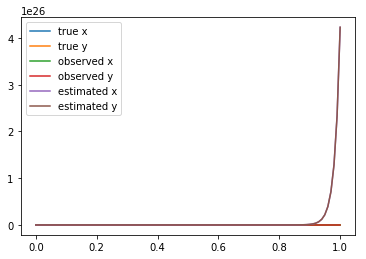

In [127]:
plt.figure()
plt.plot(t_space, np.squeeze(state_recorder[:, [0, 2]]))
plt.plot(t_space, np.squeeze(output_recorder))
plt.plot(t_space, np.squeeze(prediction_recorder[:, [0, 2]]))
plt.legend(['true x', 'true y', 'observed x', 'observed y', 'estimated x', 'estimated y'])